# SLM (DistilBERT) Fine-Tuning untuk Product/Transaction Category Classification


## 1. Setup Environment

In [1]:
!pip -q install -U transformers evaluate accelerate scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import torch

print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


## 2. Load Dataset dari Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
DATA_DIR = "/content/drive/MyDrive/Dataset Capstone Project/Dataset Terbaru untuk SLM"

TRAIN_PATH = f"{DATA_DIR}/train_products_nlp.csv"
VALID_PATH = f"{DATA_DIR}/valid_products_nlp.csv"
FULL_PATH  = f"{DATA_DIR}/products_nlp_full.csv"

for p in [TRAIN_PATH, VALID_PATH, FULL_PATH]:
    print(p, '->', os.path.exists(p))

train_df = pd.read_csv(TRAIN_PATH)
valid_df = pd.read_csv(VALID_PATH)
full_df  = pd.read_csv(FULL_PATH)

print('Full Dataset shape:', full_df.shape)
print('Train shape:', train_df.shape)
print('Valid shape:', valid_df.shape)
train_df.head()


/content/drive/MyDrive/Dataset Capstone Project/Dataset Terbaru untuk SLM/train_products_nlp.csv -> True
/content/drive/MyDrive/Dataset Capstone Project/Dataset Terbaru untuk SLM/valid_products_nlp.csv -> True
/content/drive/MyDrive/Dataset Capstone Project/Dataset Terbaru untuk SLM/products_nlp_full.csv -> True
Full Dataset shape: (1440, 2)
Train shape: (1152, 2)
Valid shape: (288, 2)


,text,label
0,garuda kacang atom 130g,Snacks
1,hokben simple set teriyaki,Dining Out
2,shinzui skin lightening soap 3x80g,Personal Care
3,clear shampoo ice cool menthol 160ml,Personal Care
4,pdam delta tirta sidoarjo,Billing & Utilities


## 3. Data Understanding

In [5]:
print(train_df.info())
print("Missing values (train):")
print(train_df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1152 non-null   object
 1   label   1152 non-null   object
dtypes: object(2)
memory usage: 18.1+ KB
None
Missing values (train):
text     0
label    0
dtype: int64


In [6]:
label_counts = train_df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
print('Jumlah kategori:', train_df['label'].nunique())
label_counts


Jumlah kategori: 11


,label,count
0,Fashion,205
1,Groceries,190
2,Dining Out,153
3,Beauty Care,151
4,Personal Care,86
5,Entertainment,80
6,Billing & Utilities,71
7,Snacks,63
8,Baby Care,55
9,Beverages,51


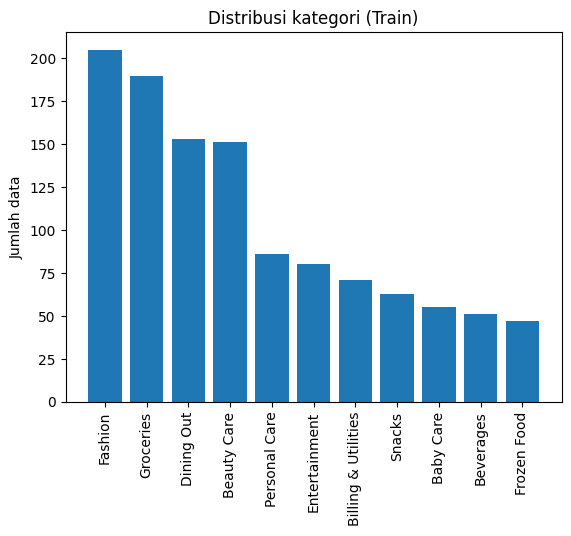

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(label_counts['label'], label_counts['count'])
plt.xticks(rotation=90)
plt.title('Distribusi kategori (Train)')
plt.ylabel('Jumlah data')
plt.show()


count    1152.000000
mean        5.263889
std         1.367927
min         2.000000
50%         5.000000
90%         7.000000
95%         8.000000
99%         8.490000
max        11.000000
Name: len_words, dtype: float64


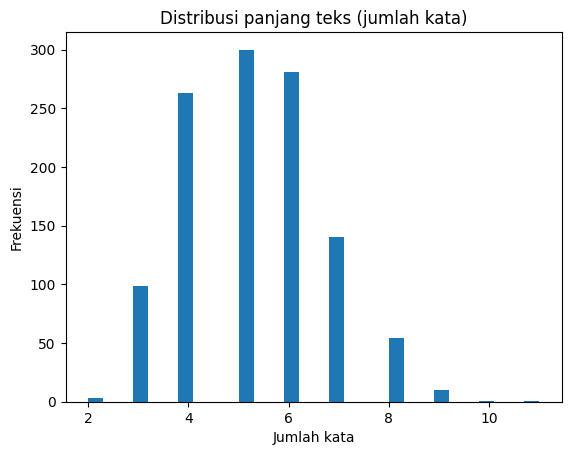

In [8]:
# Melihat panjang teks (kata)
train_df['len_words'] = train_df['text'].astype(str).str.split().map(len)
print(train_df['len_words'].describe(percentiles=[.5, .9, .95, .99]))

plt.figure()
plt.hist(train_df['len_words'], bins=30)
plt.title('Distribusi panjang teks (jumlah kata)')
plt.xlabel('Jumlah kata')
plt.ylabel('Frekuensi')
plt.show()


In [9]:
CONFUSING_PAIRS = [
    ("Personal Care", "Beauty Care"),
    ("Beverage", "Groceries"),
]

for a, b in CONFUSING_PAIRS:
    if a in train_df["label"].unique() and b in train_df["label"].unique():
        print(f"\n=== Sampel teks: {a} ===")
        print(train_df[train_df["label"] == a]["text"].head(10).to_string(index=False))
        print(f"\n=== Sampel teks: {b} ===")
        print(train_df[train_df["label"] == b]["text"].head(10).to_string(index=False))


=== Sampel teks: Personal Care ===
       shinzui skin lightening soap 3x80g
     clear shampoo ice cool menthol 160ml
   pepsodent pencegah gigi berlubang 190g
     charm body fit day wing 23cm 18 pads
lux botanicals sabun cair soft rose 400ml
     kahf skin energizing face wash 100ml
   kahf oil and acne care face wash 100ml
  biore body foam relaxing aromatic 800ml
       sabun batang lifebuoy merah 4x110g
   gillette foamy shaving cream lime 175g

=== Sampel teks: Beauty Care ===
             mustika ratu masker bengkoang bubuk
          hanasui power bright expert serum 20ml
          mustika ratu air sari mawar putih 75ml
       garnier bright complete facial foam 100ml
avoskin perfect hydrating treatment essence 30ml
                     wardah c-defense serum 17ml
                viva white soothing aloe gel 80g
                  viva liquid foundation natural
     glad2glow yuja symwhite 377 dark spot serum
                      sariayu minyak zaitun 25ml


## 4. Data Preparation untuk Fine-Tuning SLM

In [10]:
# Validasi format
assert set(train_df.columns) >= {'text','label'}
assert set(valid_df.columns) >= {'text','label'}
assert train_df['text'].astype(str).str.len().min() > 0
assert train_df['label'].astype(str).str.len().min() > 0
print('Format data OK (text & label tidak kosong)')


Format data OK (text & label tidak kosong)


In [11]:
# Encode label -> id
labels = sorted(train_df['label'].unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

train_df['label_id'] = train_df['label'].map(label2id)
valid_df['label_id'] = valid_df['label'].map(label2id)

missing_valid_labels = set(valid_df['label'].unique()) - set(train_df['label'].unique())
print('Label di valid yang tidak ada di train:', missing_valid_labels)
print('Jumlah label:', len(labels))
train_df[['text','label','label_id']].head()


Label di valid yang tidak ada di train: set()
Jumlah label: 11


,text,label,label_id
0,garuda kacang atom 130g,Snacks,10
1,hokben simple set teriyaki,Dining Out,4
2,shinzui skin lightening soap 3x80g,Personal Care,9
3,clear shampoo ice cool menthol 160ml,Personal Care,9
4,pdam delta tirta sidoarjo,Billing & Utilities,3


## 5. Tokenizer & Torch Dataset (tanpa datasets/pyarrow)

In [12]:
from transformers import AutoTokenizer

MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 64

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
from torch.utils.data import Dataset as TorchDataset

class TxDataset(TorchDataset):
    def __init__(self, df):
        self.texts = df['text'].astype(str).tolist()
        self.labels = df['label_id'].astype(int).tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_data = TxDataset(train_df)
valid_data = TxDataset(valid_df)

print('Train items:', len(train_data))
print('Valid items:', len(valid_data))
print(train_data[0])


Train items: 1152
Valid items: 288
{'input_ids': tensor([  101, 11721, 28121,  2050, 10556,  9336,  2290, 13787,  7558,  2290,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(10)}


## 6. Fine-Tuning DistilBERT

In [14]:
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    return {
        'accuracy': acc_metric.compute(predictions=y_pred, references=y_true)['accuracy'],
        'f1_macro': f1_metric.compute(predictions=y_pred, references=y_true, average='macro')['f1'],
    }

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
!pip -q install -U transformers accelerate

In [16]:
import transformers, sys
print("python:", sys.version)
print("transformers:", transformers.__version__)
print("transformers path:", transformers.__file__)

python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
transformers: 4.57.6
transformers path: /usr/local/lib/python3.12/dist-packages/transformers/__init__.py


In [17]:
!pip -q uninstall -y transformers
!pip -q install -U transformers accelerate

In [18]:
import transformers
print(transformers.__version__)

4.57.6


In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/slm_txcls",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-2785591105.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()
results = trainer.evaluate()
print(results)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.062200,1.670605,0.517361,0.239957
2,1.369700,1.166824,0.659722,0.468135
3,1.018400,0.946711,0.746528,0.667368
4,0.856000,0.874151,0.774306,0.703185


{'eval_loss': 0.8741505742073059, 'eval_accuracy': 0.7743055555555556, 'eval_f1_macro': 0.703184777888465, 'eval_runtime': 0.6991, 'eval_samples_per_second': 411.933, 'eval_steps_per_second': 12.873, 'epoch': 4.0}


## 7. Evaluasi Bisnis: Confusion Matrix & Fokus Kategori Sering Tertukar

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

pred_out = trainer.predict(valid_data)
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=1)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df


,Baby Care,Beauty Care,Beverages,Billing & Utilities,Dining Out,Entertainment,Fashion,Frozen Food,Groceries,Personal Care,Snacks
Baby Care,4,0,0,0,0,0,2,0,2,0,6
Beauty Care,0,34,0,0,0,0,0,0,2,2,0
Beverages,0,1,10,0,0,0,0,0,1,1,0
Billing & Utilities,0,0,0,14,0,4,0,0,0,0,0
Dining Out,0,0,0,0,37,0,1,0,0,0,0
Entertainment,0,0,0,0,0,16,2,0,2,0,0
Fashion,0,2,0,0,1,0,48,0,0,0,0
Frozen Food,0,0,0,0,0,0,1,6,4,0,1
Groceries,0,2,0,0,2,0,0,0,41,0,2
Personal Care,0,16,1,0,0,0,1,0,1,2,0


In [22]:
print(classification_report(y_true, y_pred, target_names=labels, digits=4))


                     precision    recall  f1-score   support

          Baby Care     0.8000    0.2857    0.4211        14
        Beauty Care     0.6182    0.8947    0.7312        38
          Beverages     0.9091    0.7692    0.8333        13
Billing & Utilities     1.0000    0.7778    0.8750        18
         Dining Out     0.9250    0.9737    0.9487        38
      Entertainment     0.8000    0.8000    0.8000        20
            Fashion     0.8727    0.9412    0.9057        51
        Frozen Food     1.0000    0.5000    0.6667        12
          Groceries     0.7193    0.8723    0.7885        47
      Personal Care     0.4000    0.0952    0.1538        21
             Snacks     0.5500    0.6875    0.6111        16

           accuracy                         0.7743       288
          macro avg     0.7813    0.6907    0.7032       288
       weighted avg     0.7749    0.7743    0.7520       288



In [23]:
def show_confusions(label_a, label_b):
    if label_a not in label2id or label_b not in label2id:
        print("Label tidak ditemukan di label2id")
        return
    a = label2id[label_a]
    b = label2id[label_b]
    print(f"\nConfusion {label_a} vs {label_b}")
    print(f"{label_a} -> {label_b}: {cm[a, b]}")
    print(f"{label_b} -> {label_a}: {cm[b, a]}")

for a, b in [("Personal Care", "Beauty Care"), ("Beverages", "Groceries")]:
    show_confusions(a, b)


Confusion Personal Care vs Beauty Care
Personal Care -> Beauty Care: 16
Beauty Care -> Personal Care: 2

Confusion Beverages vs Groceries
Beverages -> Groceries: 1
Groceries -> Beverages: 0


In [24]:
for a, b in [
    ("Personal Care", "Beauty Care"),
    ("Beverages", "Groceries")
]:
    show_confusions(a, b)


Confusion Personal Care vs Beauty Care
Personal Care -> Beauty Care: 16
Beauty Care -> Personal Care: 2

Confusion Beverages vs Groceries
Beverages -> Groceries: 1
Groceries -> Beverages: 0


## 8. Simpan Model

In [25]:
SAVE_DIR = '/content/slm_model_distilbert'
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print('Saved to:', SAVE_DIR)


Saved to: /content/slm_model_distilbert


In [26]:
OUT_DIR  = "/content/drive/MyDrive/Dataset Capstone Project/slm_model_distilbert"

!mkdir -p "{OUT_DIR}"
!cp -r "{SAVE_DIR}/." "{OUT_DIR}/"
!ls -lah "{OUT_DIR}"

total 257M
-rw------- 1 root root 1.1K Jan 21 10:08 config.json
-rw------- 1 root root 256M Jan 21 10:08 model.safetensors
-rw------- 1 root root  125 Jan 21 10:08 special_tokens_map.json
-rw------- 1 root root 1.2K Jan 21 10:08 tokenizer_config.json
-rw------- 1 root root 695K Jan 21 10:08 tokenizer.json
-rw------- 1 root root 5.8K Jan 21 10:08 training_args.bin
-rw------- 1 root root 227K Jan 21 10:08 vocab.txt


In [27]:
!df -h | grep drive

drive            15G   11G  4.9G  68% /content/drive


## 8. Uji Test Hasil Predict

In [28]:
import torch
import torch.nn.functional as F

def predict_category(texts, return_conf=False):

    single = isinstance(texts, str)
    if single:
        texts = [texts]

    model.eval()

    inputs = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=96,
        return_tensors="pt"
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        confs, idxs = torch.max(probs, dim=1)

    labels = [id2label[i.item()] for i in idxs]
    confs = [float(c.item()) for c in confs]

    if single:
        return (labels[0], confs[0]) if return_conf else labels[0]
    return (labels, confs) if return_conf else labels


In [29]:
samples = [
    "garnier bright complete facial foam 100ml",
    "kahf oil and acne care face wash 100ml",
    "teh botol sosro 450ml"
]
print(predict_category(samples))

['Beauty Care', 'Beauty Care', 'Groceries']


In [30]:
samples = [
    "Mie Gacoan Level 8",
    "Judydoll Fine Curling Mascara",
    "Batik Gheia"
]
print(predict_category(samples))

['Dining Out', 'Beauty Care', 'Fashion']


In [31]:
samples = [
    "Hao Encim T5015 Batik Kerja",
    "Oxford Society Witney Half Zip Jacket",
    "Telkomsel Super Seru"
]
print(predict_category(samples))

['Groceries', 'Fashion', 'Billing & Utilities']


In [32]:
JSONL_PATH = "/content/drive/MyDrive/Dataset Capstone Project/receipt_new.jsonl"

In [33]:
import json

def load_jsonl(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
    return data

transactions = load_jsonl(JSONL_PATH)
print("Jumlah transaksi:", len(transactions))
transactions[0]

Jumlah transaksi: 10


{'transaction_id': 'TX91000001',
 'merchant': 'Zalora',
 'receipt_text_raw': 'ZALORA\nBlouse Wanita                      Rp 129.000,-\nCelana Kulot                      Rp 179.000,-\n\nTOTAL                              Rp 308.000,-\nPayment: Kredit',
 'confidence': 0.9,
 'error_flag': False,
 'ocr_noise_type': None}

In [34]:
import re

TOTAL_PAT = re.compile(r"^\s*(total|subtotal|payment|bayar)\b", re.I)
RP_SPLIT_PAT = re.compile(r"\bRp\b|\brp\b", re.I)

def extract_items_from_receipt(receipt_text_raw: str):
    items = []
    for raw_line in receipt_text_raw.splitlines():
        line = raw_line.strip()
        if not line:
            continue

        if TOTAL_PAT.search(line):
            continue

        if re.search(r"\brp\b", line.lower()):

            name = RP_SPLIT_PAT.split(line, maxsplit=1)[0].strip()
            name = re.sub(r"\bx\s*\d+\b", "", name, flags=re.I).strip()
            name = re.sub(r"[^a-zA-Z0-9\s\-\/]", " ", name).strip()
            name = re.sub(r"\s+", " ", name).strip()

            if len(name) >= 3:
                items.append(name.lower())

    return items

In [35]:
from collections import Counter
import re

_PATTERNS = {
    "Baby Care": re.compile(r"(?<!\w)(popok|pampers|diaper|susu\s*formula|formula\s*bayi|tisu\s*basah\s*bayi|baby\s*wipes|baby\s*wash)(?!\w)", re.I),
    "Beverages": re.compile(r"(?<!\w)(minuman|isotonik|teh|kopi|soda|jus|juice|milk\s*tea|boba|latte|uht|yogurt\s*drink)(?!\w)", re.I),
    "Snacks": re.compile(r"(?<!\w)(snack|biskuit|wafer|keripik|chips|cokelat|chocolate|permen|candy|popcorn)(?!\w)", re.I),
    "Billing & Utilities": re.compile(r"(?<!\w)(pln|token\s*listrik|listrik|pdam|internet|wifi|pulsa|paket\s*data|bpjs)(?!\w)", re.I),
}

def _apply_keyword_rules(item_text, pred_label):
    for label, pat in _PATTERNS.items():
        if pat.search(item_text):
            return label
    return pred_label


def predict_transaction_category(receipt_text_raw, *, unknown_threshold=None):

    items = extract_items_from_receipt(receipt_text_raw)

    if not items:
        return predict_category(receipt_text_raw), []

    item_texts = [f"produk: {it}" for it in items]

    if unknown_threshold is None:
        item_preds = predict_category(item_texts)
        item_confs = None
    else:
        item_preds, item_confs = predict_category(item_texts, return_conf=True)

    if isinstance(item_preds, str):
        item_preds = [item_preds]
        if item_confs is not None:
            item_confs = [item_confs]

    fixed_preds = []
    for i, pred in enumerate(item_preds):
        it = items[i]
        pred2 = _apply_keyword_rules(it, pred)
        if item_confs is not None and item_confs[i] < float(unknown_threshold):
            pred2 = "Other"
        fixed_preds.append(pred2)

    unique = set(fixed_preds)
    transaction_cat = fixed_preds[0] if len(unique) == 1 else "Mixed"

    return transaction_cat, list(zip(items, fixed_preds))

In [38]:
test_ids = {"TX91000001", "TX91000009"}

for tx in transactions:
    if tx["transaction_id"] in test_ids:
        final_cat, item_details = predict_transaction_category(
            tx["receipt_text_raw"]
        )

        print("Transaction ID:", tx["transaction_id"])
        print("Predicted Category:", final_cat)
        print(item_details)
        print("-" * 50)

Transaction ID: TX91000001
Predicted Category: Fashion
[('blouse wanita', 'Fashion'), ('celana kulot', 'Fashion')]
--------------------------------------------------
Transaction ID: TX91000009
Predicted Category: Mixed
[('tiket film dewasa', 'Entertainment'), ('popcorn caramel', 'Snacks')]
--------------------------------------------------
